# NHL 2009-2018 Draft data

Dataset downloaded from [Kaggle](http://localhost:8888/?token=b1eb61f8ed72cf51005640919abafb625e74268313819ce3).

# Exploratory Data Analysis

This notebook presents Exploratory Data Analysis performed on modified NHL Draft dataset. Previous steps included data cleaning and feature extraction. Summary of each step is presented below, for details see notebook `notebooks/feature_extraction/nhl_cleanup_extraction.ipynb`.

Cleanup summary:

* summarized positions
    * corrected for consistency
    * C/RW, C/LW, _etc._, C/W, F = C
    * L/RW, W = RW
    * player who can play center are assumed to be centers for the purposes of this analysis
    * universal (left/right) wingers are assumed to be right wingers
    * for details, see notebook `notebooks/feature_extraction/nhl_cleanup_extraction.ipynb`

New features added during feature extraction:

* `year`: int, year of NHL draft, extracted from .csv file names
* `num_teams`: int, number of teams in each draft year
* `round_ratio`: float, ratio of each pick: 
    * $\text{round_ratio}=\large{\frac{\text{# Overall}}{\text{number of teams}}}$ 
    * number of teams represents number of picks per round
    * each overall pick number (e.g., 171) is divided by the number of picks per round to determine in which round (and how late in the round, via the ratio) was each prospect selected
    * \- 1 is needed to ensure proper boundary between rounds
    * so, for example, for pick #171 $\text{round ratio}=\frac{171 - 1}{30} = 5.67$
* `round`: int, round in which a prospect was selected
    * `round_ratio` is rounded down and 1 is added
    * $\text{round} = \text{int}(\text{round ratio}) + 1$
* `1st_round`: boolean, whether the prospect was selected in the $1^{st}$ round
    * one-hot encoding for $1^{st}$ round picks
    * True if `round` == 1, False otherwise
* `gpg`: float, average goals per game
* `apg`: float, average assists per game
* `ppg`: float, average points per game
* for details, see notebook `notebooks/feature_extraction/nhl_cleanup_extraction.ipynb`

## Load data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time
sns.set()

In [55]:
draft_data_path = '../../data/nhl_draft_picks_2009-2018.csv'
t = time()
df = pd.read_csv(draft_data_path)
df = df.rename(columns={'Unnamed: 0': 'id'})
elapsed = time() - t
print("----- DataFrame with NHL Draft Data loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame with NHL Draft Data loaded
in 0.05 seconds
with 2,119 rows
and 29 columns
-- Column names:
 Index(['id', 'Overall', 'Team', 'Player', 'Nat.', 'Pos', 'Age', 'To',
       'Amateur Team', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM', 'GP.1', 'W', 'L',
       'T/O', 'SV%', 'GAA', 'year', 'num_teams', 'round_ratio', 'round',
       '1st_round', 'gpg', 'apg', 'ppg'],
      dtype='object')


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 29 columns):
id              2119 non-null int64
Overall         2119 non-null int64
Team            2119 non-null object
Player          2119 non-null object
Nat.            2118 non-null object
Pos             2118 non-null object
Age             2118 non-null float64
To              728 non-null float64
Amateur Team    2118 non-null object
GP              728 non-null float64
G               728 non-null float64
A               728 non-null float64
PTS             728 non-null float64
+/-             724 non-null float64
PIM             728 non-null float64
GP.1            55 non-null float64
W               54 non-null float64
L               54 non-null float64
T/O             54 non-null float64
SV%             55 non-null float64
GAA             55 non-null float64
year            2119 non-null int64
num_teams       2119 non-null int64
round_ratio     2119 non-null float64
round        

## Exploring variables

### Total picks by each team

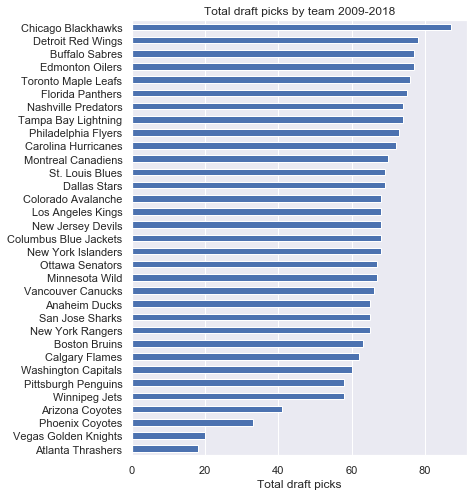

In [160]:
ax = df['Team'].value_counts().sort_values()\
    .plot(kind='barh', figsize=(6, 8),
          title='Total draft picks by team 2009-2018')
ax.set_xlabel("Total draft picks")
ax.grid(axis='y')

### Total #1 overall picks by each team

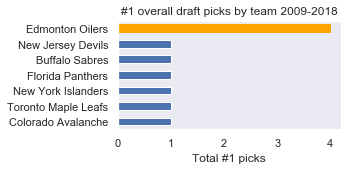

In [161]:
mask = df['Overall'] == 1
ax = df.loc[mask, 'Team'].value_counts().sort_values()\
        .plot(kind='barh', figsize=(4, 2),
              title='#1 overall draft picks by team 2009-2018')
ax.get_children()[6].set_color('orange')
ax.set_xlabel("Total #1 picks")
ax.grid(False);

### Players drafted by nationality

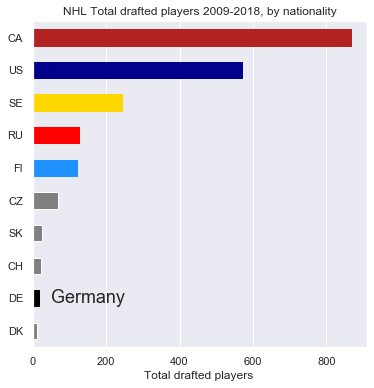

In [162]:
ax = df['Nat.'].value_counts()\
    .sort_values().tail(10)\
    .plot(kind='barh', figsize=(6, 6), color='gray',
          title='NHL Total drafted players 2009-2018, by nationality')
ax.get_children()[9].set_color('firebrick')
ax.get_children()[8].set_color('darkblue')
ax.get_children()[7].set_color('gold')
ax.get_children()[6].set_color('red')
ax.get_children()[5].set_color('dodgerblue')
ax.get_children()[1].set_color('black')
ax.text(50, 1, "Germany", fontsize=18, va='center')
ax.grid(axis='y')
ax.set_xlabel("Total drafted players ");

### #1 Overall draft picks, by nationality

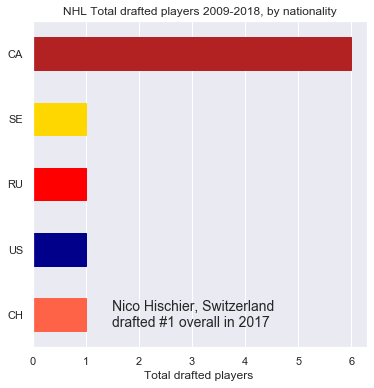

In [205]:
mask = df['Overall'] == 1
ax = df.loc[mask, 'Nat.'].value_counts()\
    .sort_values()\
    .plot(kind='barh', figsize=(6, 6), color='gray',
          title='NHL Total drafted players 2009-2018, by nationality')
ax.get_children()[4].set_color('firebrick')
ax.get_children()[1].set_color('darkblue')
ax.get_children()[3].set_color('gold')
ax.get_children()[2].set_color('red')
ax.get_children()[0].set_color('tomato')
ax.grid(axis='y')
ax.set_xlabel("Total drafted players ")
ax.text(1.5, 0, "Nico Hischier, Switzerland"
                "\ndrafted #1 overall in 2017",
                fontsize=14, va='center');

### Players drafted, by each position

For all players and for players drafter in the $1^{st}$ round.

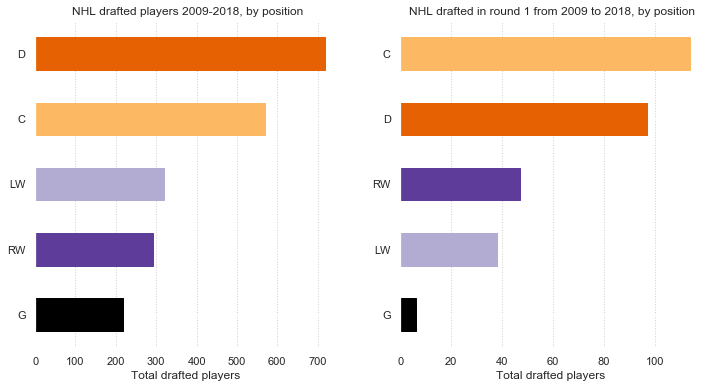

In [359]:
f, axes = plt.subplots(nrows=1, ncols=2,
                       figsize=(12, 6))
df['Pos'].value_counts()\
    .sort_values().tail(5)\
    .plot(kind='barh', color='gray',
          title='NHL drafted players 2009-2018, by position',
          ax=axes[0])
axes[0].get_children()[4].set_color('#e66101')
axes[0].get_children()[3].set_color('#fdb863')
axes[0].get_children()[2].set_color('#b2abd2')
axes[0].get_children()[1].set_color('#5e3c99')
axes[0].get_children()[0].set_color('black')
axes[0].set_facecolor('white')
axes[0].grid(axis='x', linestyle=':', color='k', alpha=0.2)
axes[0].set_xlabel("Total drafted players ")

mask = df['round'] == 1
df.loc[mask, 'Pos'].value_counts()\
    .sort_values().tail(5)\
    .plot(kind='barh', color='gray',
          title='NHL drafted in round 1 from 2009 to 2018, by position',
          ax=axes[1])
axes[1].get_children()[4].set_color('#fdb863')
axes[1].get_children()[3].set_color('#e66101')
axes[1].get_children()[2].set_color('#5e3c99')
axes[1].get_children()[1].set_color('#b2abd2')
axes[1].get_children()[0].set_color('black')
axes[1].set_facecolor('white')
axes[1].grid(axis='x', linestyle=':', color='k', alpha=0.2)
axes[1].set_xlabel("Total drafted players ")

plt.show()

### Age of drafted players

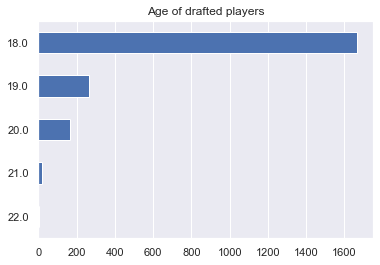

In [229]:
ax = df['Age'].value_counts().sort_values()\
    .plot(kind='barh',
          title="Age of drafted players")
ax.grid(axis='y')

### Top 10 amateur teams, for all players and $1^{st}$ round prospects

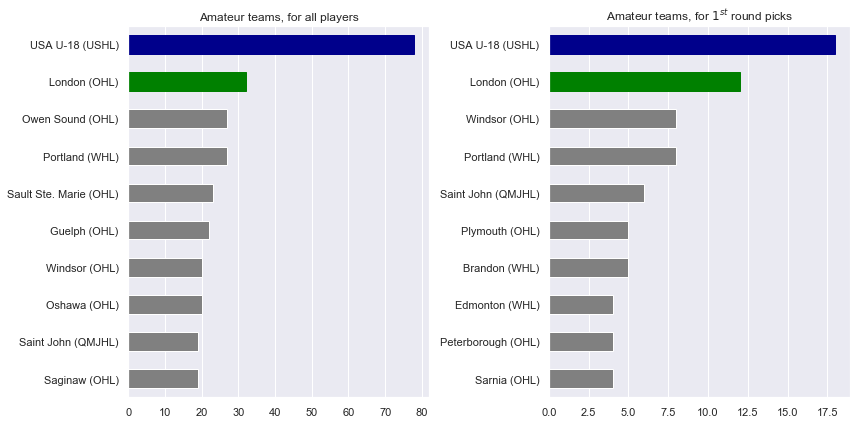

In [12]:
f, axes = plt.subplots(nrows=1, ncols=2,
                       figsize=(12, 6))
df['Amateur Team']\
    .value_counts().sort_values().tail(10)\
    .plot(kind='barh', color='gray', ax=axes[0],
          title='Amateur teams, for all players')
axes[0].grid(axis='y')
axes[0].get_children()[9].set_color('darkblue')
axes[0].get_children()[8].set_color('green')


mask = df['1st_round'] == True
df.loc[mask, 'Amateur Team']\
    .value_counts().sort_values().tail(10)\
    .plot(kind='barh', color='gray', ax=axes[1],
          title='Amateur teams, for $1^{st}$ round picks')
axes[1].grid(axis='y')
axes[1].get_children()[9].set_color('darkblue')
axes[1].get_children()[8].set_color('green')

plt.tight_layout()

### Number of games played, for all players

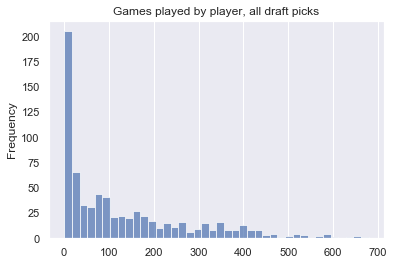

In [13]:
ax = df['GP'].plot(kind='hist', bins=40, alpha=0.7,
    title='Games played by player, all draft picks')
ax.grid(axis='y')

### Number of games played and pick round

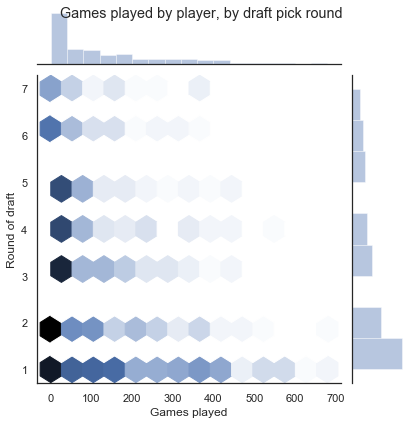

In [284]:
with sns.axes_style('white'):
    g = sns.jointplot(data=df, x='GP', y='round',
                   kind='hex')
    g.fig.suptitle("Games played by player, by draft pick round")
    g.set_axis_labels("Games played", "Round of draft")

### Goals and assists distribution
By position and for all players vs $1^{st}$ round picks.

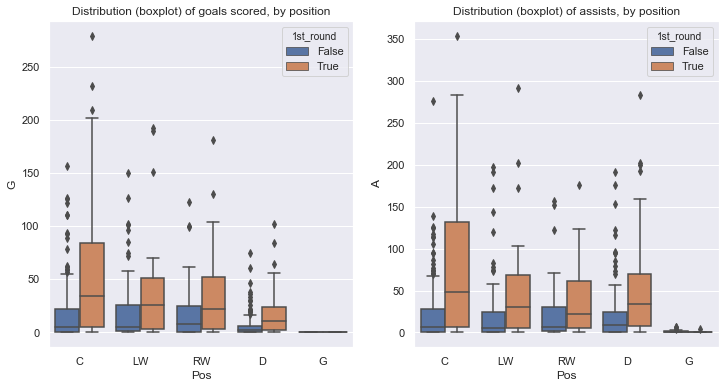

In [27]:
pos_order = ["C", "LW", "RW", "D", "G"]

f, axes = plt.subplots(nrows=1, ncols=2,
                     figsize=(12, 6))

sns.boxplot(data=df, x='Pos', y='G',
            order=pos_order, hue='1st_round',
            ax=axes[0])
axes[0].set_title("Distribution (boxplot) of goals scored, by position");

sns.boxplot(data=df, x='Pos', y='A',
            order=pos_order, hue='1st_round',
            ax=axes[1])
axes[1].set_title("Distribution (boxplot) of assists, by position");

### Distribution of goals by position
For all players and $1^{st}$ round picks.

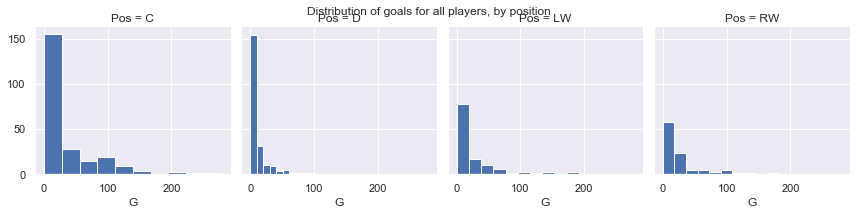

In [54]:
mask = df['Pos'] != 'G'
g = sns.FacetGrid(df[mask], col='Pos')
g.map(plt.hist, 'G')
g.fig.suptitle("Distribution of goals for all players, by position");

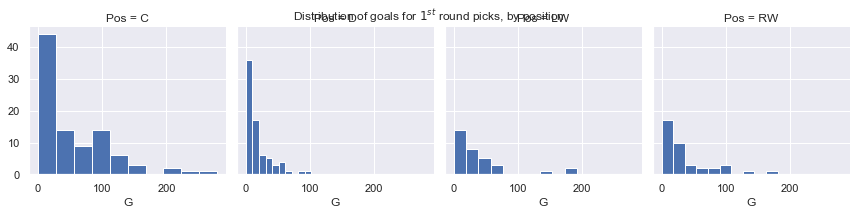

In [53]:
mask1 = df['1st_round'] == True
mask2 = df['Pos'] != 'G'
g = sns.FacetGrid(df[mask1 & mask2], col='Pos')
g.map(plt.hist, 'G')
g.fig.suptitle("Distribution of goals for $1^{st}$ round picks, by position");

In [42]:
df.columns

Index(['id', 'Overall', 'Team', 'Player', 'Nat.', 'Pos', 'Age', 'To',
       'Amateur Team', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM', 'GP.1', 'W', 'L',
       'T/O', 'SV%', 'GAA', 'year', 'num_teams', 'round_ratio', 'round',
       '1st_round'],
      dtype='object')

### Goals and assists vs overall pick number, by position
Coloured by the round of the pick.

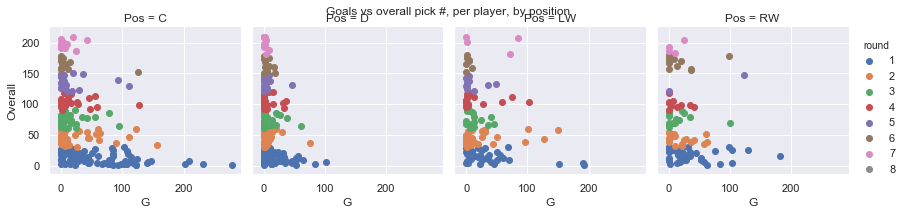

In [51]:
mask = df['Pos'] != 'G'
g = sns.FacetGrid(df[mask], col='Pos', hue='round')
g.map(plt.scatter, 'G', 'Overall')
g.fig.suptitle("Goals vs overall pick #, per player, by position")
g.add_legend();

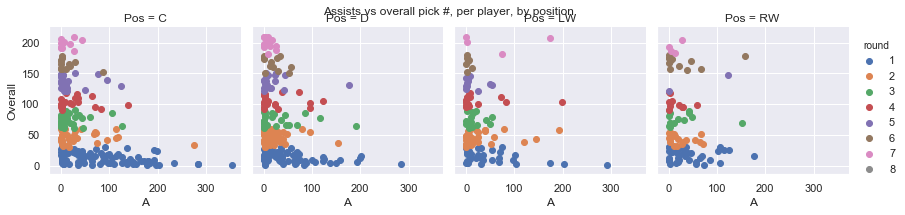

In [52]:
mask = df['Pos'] != 'G'
g = sns.FacetGrid(df[mask], col='Pos', hue='round')
g.map(plt.scatter, 'A', 'Overall')
g.fig.suptitle("Assists vs overall pick #, per player, by position")
g.add_legend();

In [ ]:
df['']